# 多项式回归与正则化

## 目标
- 理解多项式回归的原理
- 理解过拟合和欠拟合
- 掌握Ridge和Lasso正则化
- 特征缩放的重要性
- 学习率调节和正则化参数选择

---

## 1. 理论简介

### 多项式回归
当数据不是线性关系时，我们可以使用多项式特征来拟合更复杂的曲线。

例如，对于二次多项式：
$$y = w_0 + w_1x + w_2x^2$$

本质上仍然是线性回归，只是特征变成了 $[1, x, x^2]$

### 过拟合与欠拟合
- **欠拟合（Underfitting）**：模型太简单，无法捕捉数据模式
- **过拟合（Overfitting）**：模型太复杂，学习了数据中的噪声
- **刚刚好**：模型复杂度适中，泛化能力强

### 正则化
正则化通过在损失函数中添加惩罚项来防止过拟合。

#### Ridge回归（L2正则化）
$$L = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \alpha\sum_{j=1}^{p}w_j^2$$

- 让权重变小但不为0
- 适合特征相关性高的情况

#### Lasso回归（L1正则化）
$$L = \frac{1}{n}\sum_{i=1}^{n}(y_i - \hat{y}_i)^2 + \alpha\sum_{j=1}^{p}|w_j|$$

- 让某些权重变为0（特征选择）
- 适合特征稀疏的情况

#### ElasticNet（L1+L2）
$$L = MSE + \alpha_1\sum|w_j| + \alpha_2\sum w_j^2$$

- 结合Ridge和Lasso的优点

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

np.random.seed(42)
plt.style.use('seaborn-v0_8')
sns.set_palette('husl')
plt.rcParams['font.sans-serif'] = [
        'Arial Unicode MS',  # macOS通用
        'PingFang SC',       # macOS系统字体
        'STHeiti',           # 华文黑体
        'Heiti TC',          # 黑体-繁
        'SimHei',            # 黑体
    ]
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

print('✓ 所有库导入成功')

✓ 所有库导入成功


## 2. 多项式回归

### 生成非线性数据

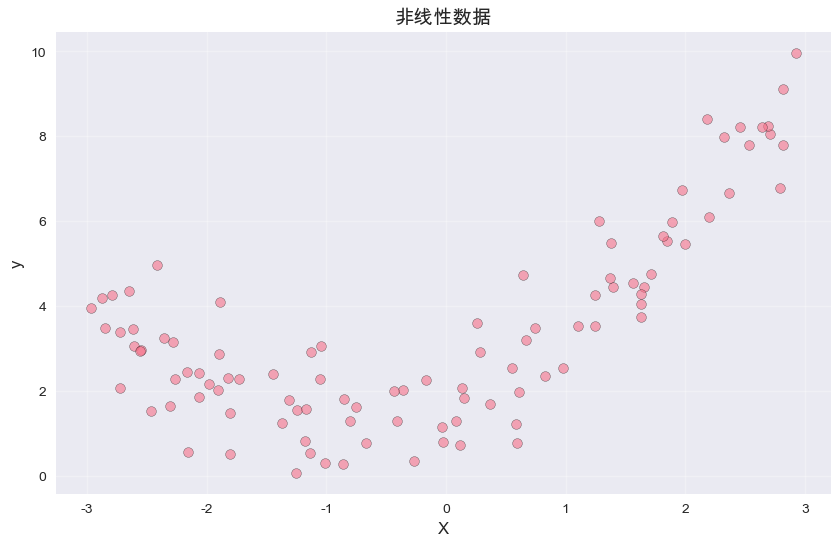

In [2]:
# 生成非线性数据 y = 0.5x^2 + x + 2 + noise
n_samples = 100
X = 6 * np.random.rand(n_samples, 1) - 3
y = 0.5 * X**2 + X + 2 + np.random.randn(n_samples, 1)

# 可视化
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, edgecolors='k')
plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('非线性数据', fontsize=14)
plt.grid(True, alpha=0.3)
plt.show()

### 对比不同阶数的多项式

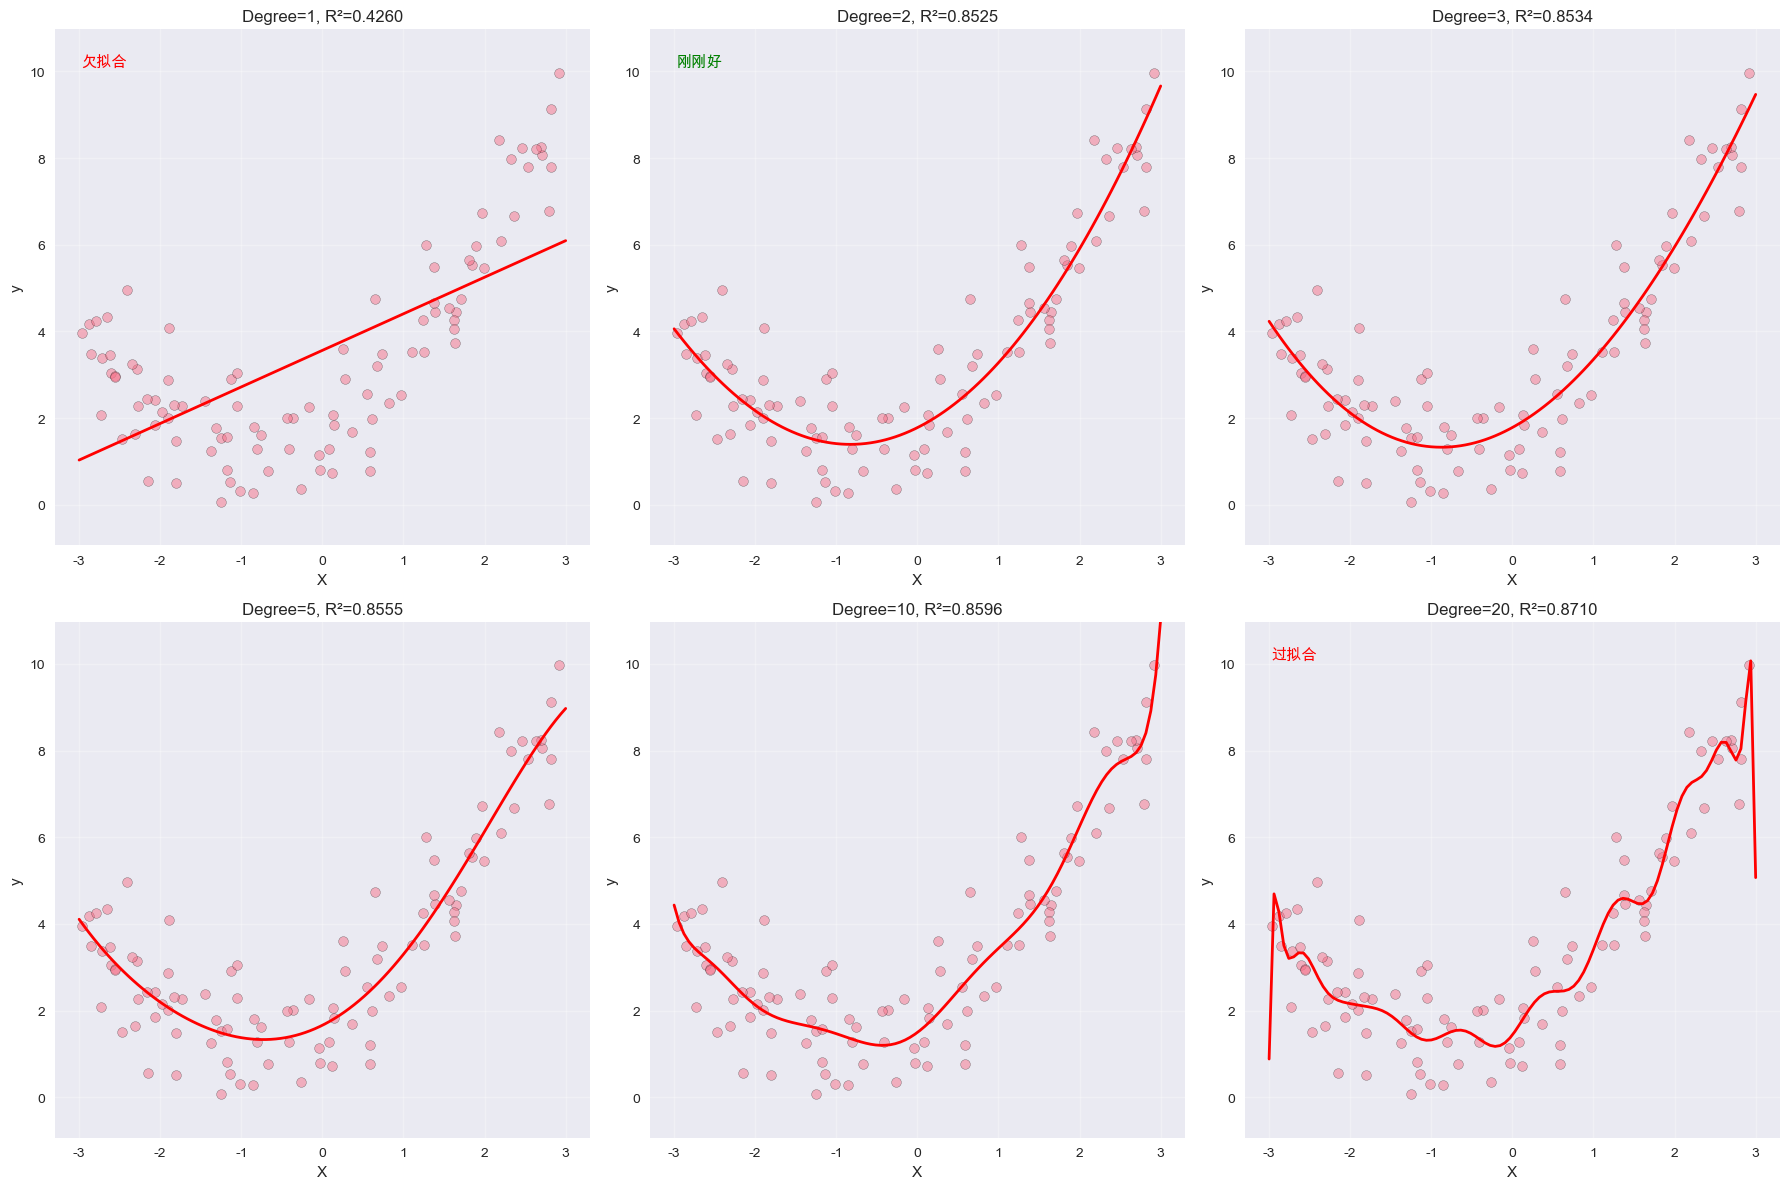

In [3]:
def plot_polynomial_regression(X, y, degrees):
    """
    绘制不同阶数的多项式回归结果
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    X_test = np.linspace(-3, 3, 100).reshape(-1, 1)
    
    for i, degree in enumerate(degrees):
        # 创建多项式特征
        poly_features = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly_features.fit_transform(X)
        X_test_poly = poly_features.transform(X_test)
        
        # 训练模型
        model = LinearRegression()
        model.fit(X_poly, y)
        y_pred = model.predict(X_test_poly)
        
        # 计算R²
        y_train_pred = model.predict(X_poly)
        r2 = r2_score(y, y_train_pred)
        
        # 绘图
        axes[i].scatter(X, y, alpha=0.5, edgecolors='k')
        axes[i].plot(X_test, y_pred, 'r-', linewidth=2)
        axes[i].set_xlabel('X', fontsize=11)
        axes[i].set_ylabel('y', fontsize=11)
        axes[i].set_title(f'Degree={degree}, R²={r2:.4f}', fontsize=12)
        axes[i].set_ylim([y.min() - 1, y.max() + 1])
        axes[i].grid(True, alpha=0.3)
        
        # 判断拟合情况
        if degree == 1:
            axes[i].text(0.05, 0.95, '欠拟合', 
                        transform=axes[i].transAxes, 
                        fontsize=11, color='red',
                        verticalalignment='top')
        elif degree > 10:
            axes[i].text(0.05, 0.95, '过拟合', 
                        transform=axes[i].transAxes, 
                        fontsize=11, color='red',
                        verticalalignment='top')
        elif degree == 2:
            axes[i].text(0.05, 0.95, '刚刚好', 
                        transform=axes[i].transAxes, 
                        fontsize=11, color='green',
                        verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

# 测试不同阶数
degrees = [1, 2, 3, 5, 10, 20]
plot_polynomial_regression(X, y, degrees)

### 学习曲线分析

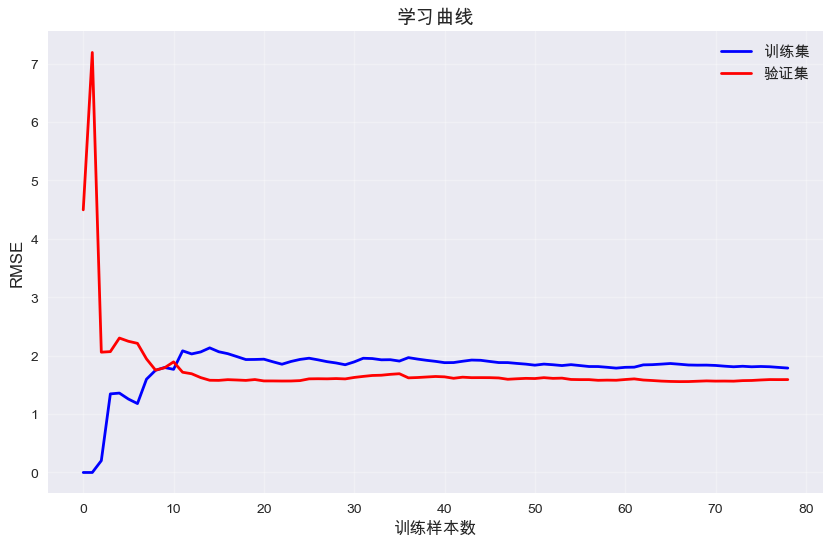

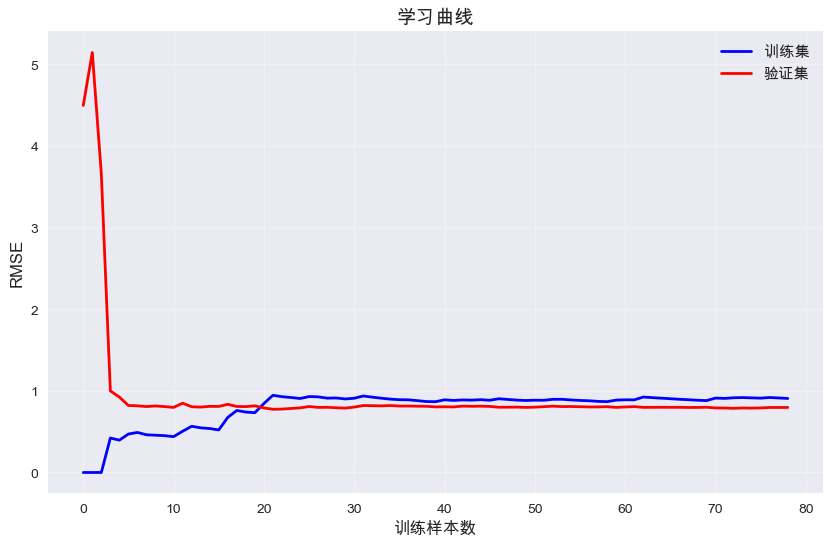

In [4]:
def plot_learning_curves(model, X, y):
    """
    绘制学习曲线（训练集和验证集误差 vs 训练样本数）
    """
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
    
    train_errors, val_errors = [], []
    
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    
    plt.figure(figsize=(10, 6))
    plt.plot(np.sqrt(train_errors), 'b-', linewidth=2, label='训练集')
    plt.plot(np.sqrt(val_errors), 'r-', linewidth=2, label='验证集')
    plt.xlabel('训练样本数', fontsize=12)
    plt.ylabel('RMSE', fontsize=12)
    plt.title('学习曲线', fontsize=14)
    plt.legend(fontsize=11)
    plt.grid(True, alpha=0.3)
    plt.show()

# 欠拟合模型（线性）
lin_model = LinearRegression()
plot_learning_curves(lin_model, X, y)

# 刚刚好的模型（二次）
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)
poly_model = LinearRegression()
plot_learning_curves(poly_model, X_poly, y)

## 3. 正则化

### Ridge回归（L2正则化）

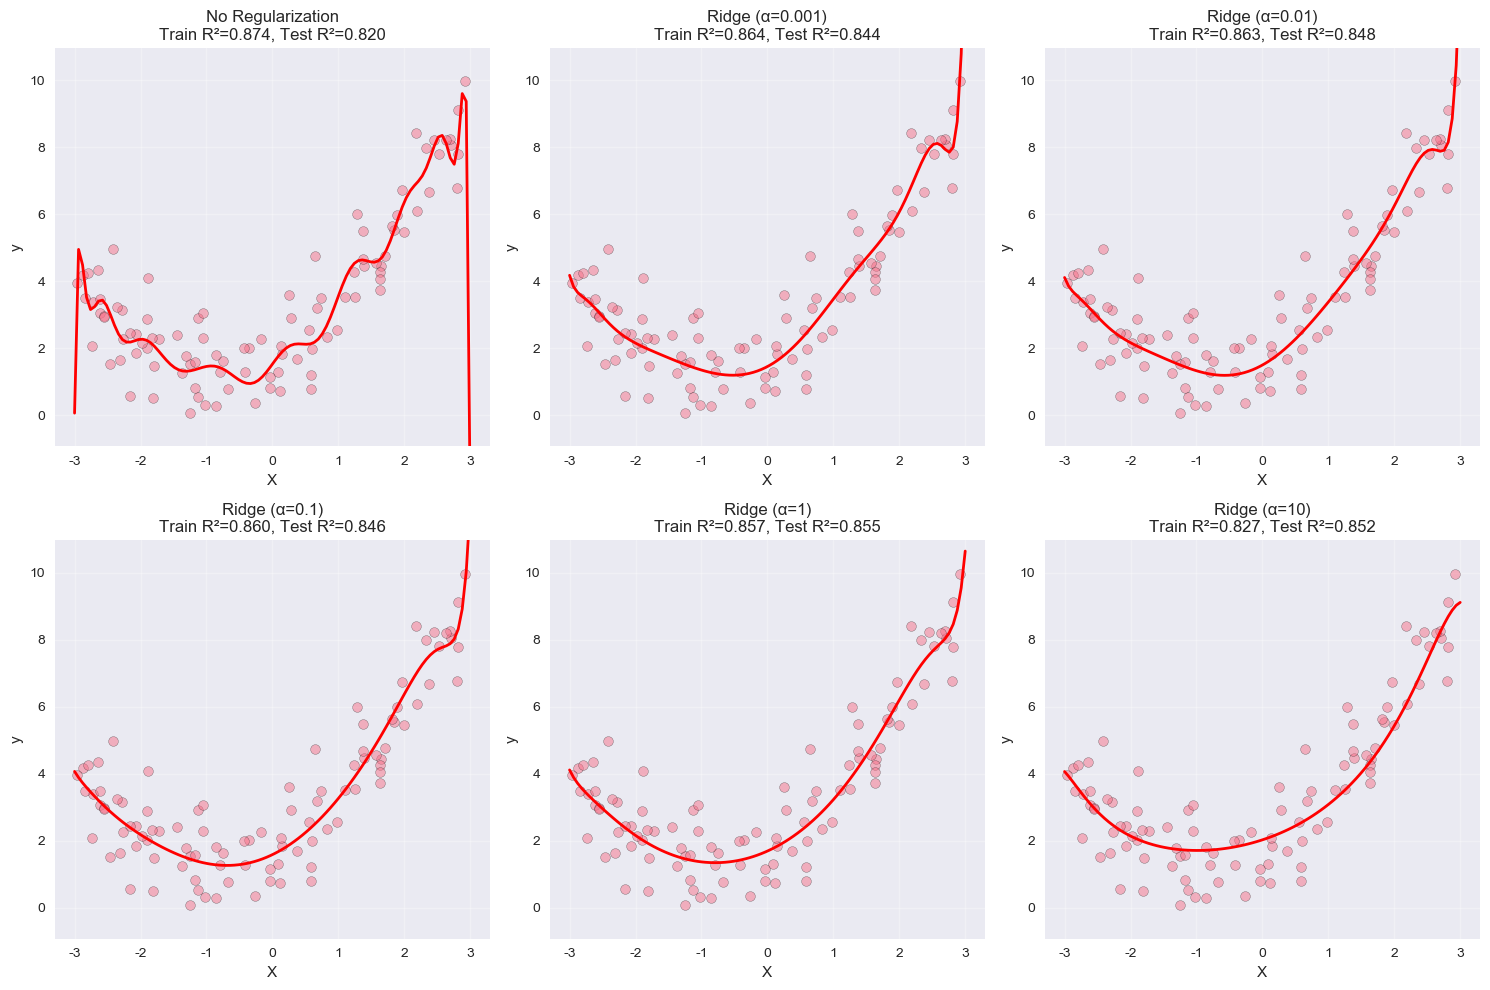

In [5]:
# 生成高阶多项式特征（容易过拟合）
poly_features = PolynomialFeatures(degree=20, include_bias=False)
X_poly = poly_features.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_poly, y, test_size=0.2, random_state=42)

# 特征缩放（正则化之前必须做）
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 对比不同的alpha值
alphas = [0, 0.001, 0.01, 0.1, 1, 10]

plt.figure(figsize=(15, 10))
X_plot = np.linspace(-3, 3, 100).reshape(-1, 1)
X_plot_poly = poly_features.transform(X_plot)
X_plot_scaled = scaler.transform(X_plot_poly)

for i, alpha in enumerate(alphas, 1):
    plt.subplot(2, 3, i)
    
    if alpha == 0:
        model = LinearRegression()
        title = 'No Regularization'
    else:
        model = Ridge(alpha=alpha)
        title = f'Ridge (α={alpha})'
    
    model.fit(X_train_scaled, y_train)
    y_plot = model.predict(X_plot_scaled)
    
    # 计算分数
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    plt.scatter(X, y, alpha=0.5, edgecolors='k')
    plt.plot(X_plot, y_plot, 'r-', linewidth=2)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'{title}\nTrain R²={train_score:.3f}, Test R²={test_score:.3f}')
    plt.ylim([y.min() - 1, y.max() + 1])
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Lasso回归（L1正则化）

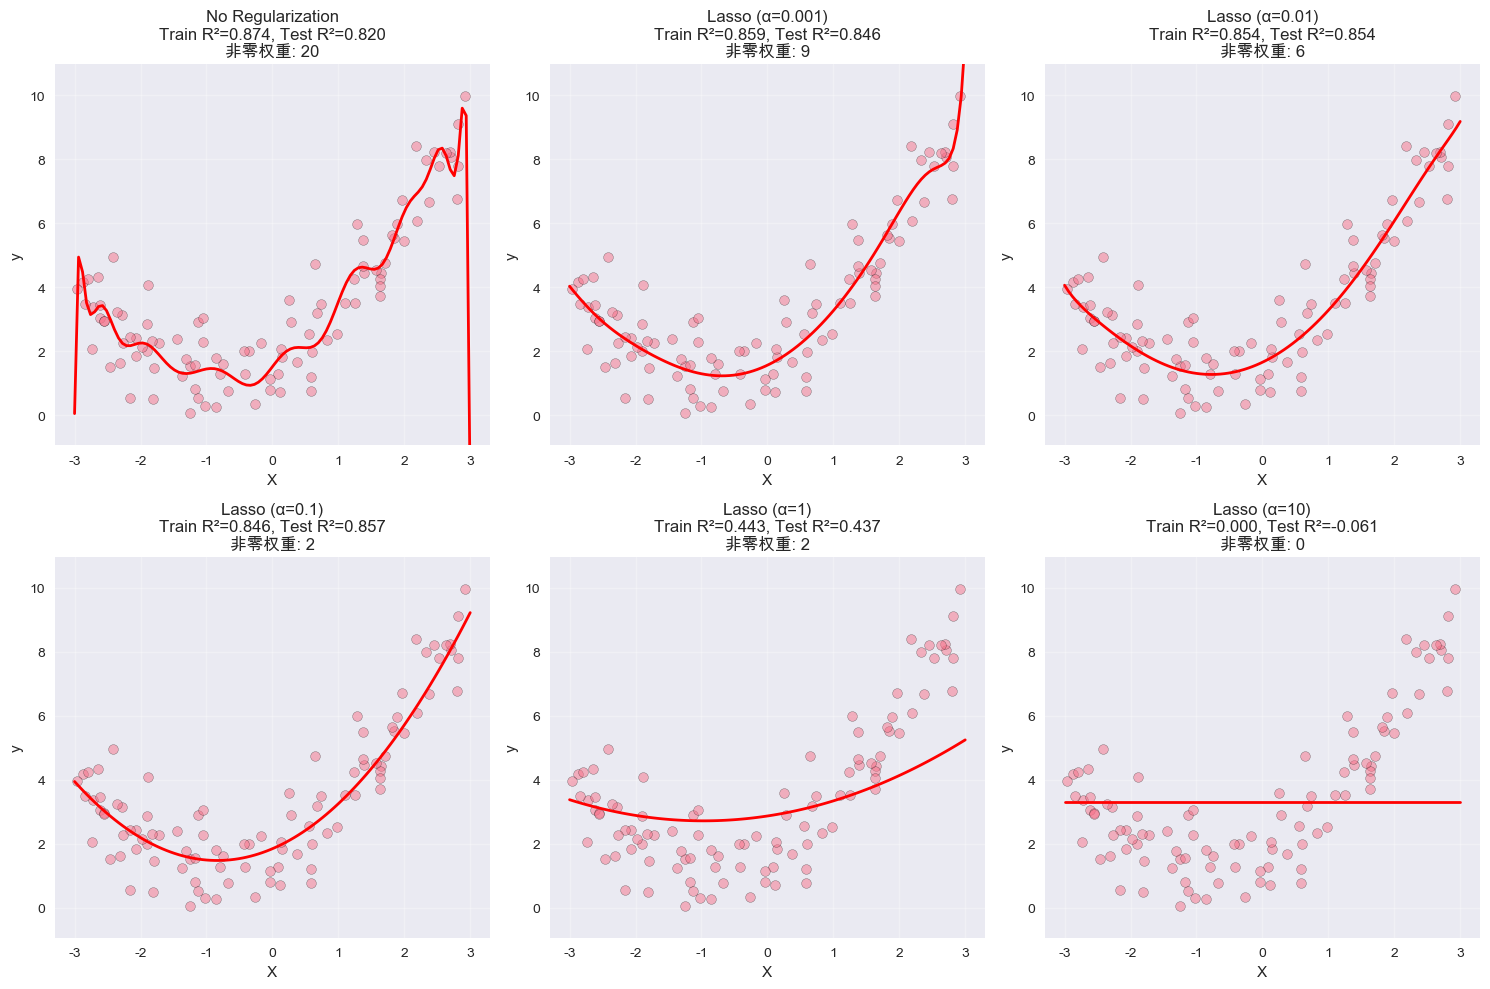

In [6]:
# 对比不同的alpha值
plt.figure(figsize=(15, 10))

for i, alpha in enumerate(alphas, 1):
    plt.subplot(2, 3, i)
    
    if alpha == 0:
        model = LinearRegression()
        title = 'No Regularization'
    else:
        model = Lasso(alpha=alpha, max_iter=10000)
        title = f'Lasso (α={alpha})'
    
    model.fit(X_train_scaled, y_train.ravel())
    y_plot = model.predict(X_plot_scaled)
    
    train_score = model.score(X_train_scaled, y_train)
    test_score = model.score(X_test_scaled, y_test)
    
    # 计算非零权重数量
    if hasattr(model, 'coef_'):
        n_nonzero = np.sum(np.abs(model.coef_) > 1e-5)
    else:
        n_nonzero = len(model.coef_)
    
    plt.scatter(X, y, alpha=0.5, edgecolors='k')
    plt.plot(X_plot, y_plot, 'r-', linewidth=2)
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title(f'{title}\nTrain R²={train_score:.3f}, Test R²={test_score:.3f}\n非零权重: {n_nonzero}')
    plt.ylim([y.min() - 1, y.max() + 1])
    plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Ridge vs Lasso权重对比

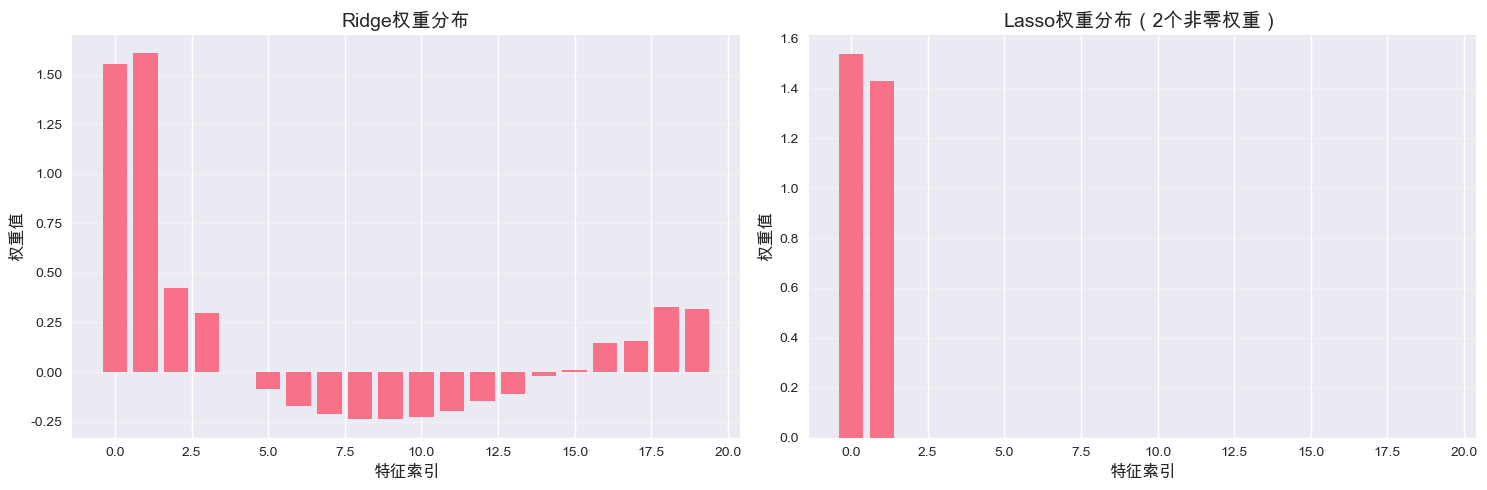

Ridge权重范围: -0.23885452719632172 ~ 1.6076851013902251
Lasso权重范围: 0.0 ~ 1.5372412858949618
Lasso将 18 个权重置为0


In [7]:
ridge = Ridge(alpha=1)
lasso = Lasso(alpha=0.1, max_iter=10000)

ridge.fit(X_train_scaled, y_train)
lasso.fit(X_train_scaled, y_train.ravel())

# 绘制权重
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Ridge权重
axes[0].bar(range(len(ridge.coef_[0])), ridge.coef_[0])
axes[0].set_xlabel('特征索引', fontsize=12)
axes[0].set_ylabel('权重值', fontsize=12)
axes[0].set_title('Ridge权重分布', fontsize=14)
axes[0].grid(True, alpha=0.3, axis='y')

# Lasso权重
axes[1].bar(range(len(lasso.coef_)), lasso.coef_)
axes[1].set_xlabel('特征索引', fontsize=12)
axes[1].set_ylabel('权重值', fontsize=12)
axes[1].set_title(f'Lasso权重分布（{np.sum(np.abs(lasso.coef_) > 1e-5)}个非零权重）', fontsize=14)
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print('Ridge权重范围:', ridge.coef_[0].min(), '~', ridge.coef_[0].max())
print('Lasso权重范围:', lasso.coef_.min(), '~', lasso.coef_.max())
print(f'Lasso将 {np.sum(np.abs(lasso.coef_) < 1e-5)} 个权重置为0')

## 4. 超参数调优

### 使用交叉验证选择最佳alpha

In [19]:
from sklearn.linear_model import RidgeCV, LassoCV

# 定义候选alpha值
alphas = np.logspace(-3, 3, 50)

# Ridge交叉验证
ridge_cv = RidgeCV(alphas=alphas, cv=5)
ridge_cv.fit(X_train_scaled, y_train)

# Lasso交叉验证
lasso_cv = LassoCV(alphas=alphas, cv=5, max_iter=50000)
lasso_cv.fit(X_train_scaled, y_train.ravel())

print(f'Ridge最佳alpha: {ridge_cv.alpha_:.4f}')
print(f'Ridge测试集R²: {ridge_cv.score(X_test_scaled, y_test):.4f}')
print(f'\nLasso最佳alpha: {lasso_cv.alpha_:.4f}')
print(f'Lasso测试集R²: {lasso_cv.score(X_test_scaled, y_test):.4f}')
print(f'Lasso选择的特征数: {np.sum(np.abs(lasso_cv.coef_) > 1e-5)}/{len(lasso_cv.coef_)}')

Ridge最佳alpha: 1.5264
Ridge测试集R²: 0.8589

Lasso最佳alpha: 0.0687
Lasso测试集R²: 0.8581
Lasso选择的特征数: 2/20


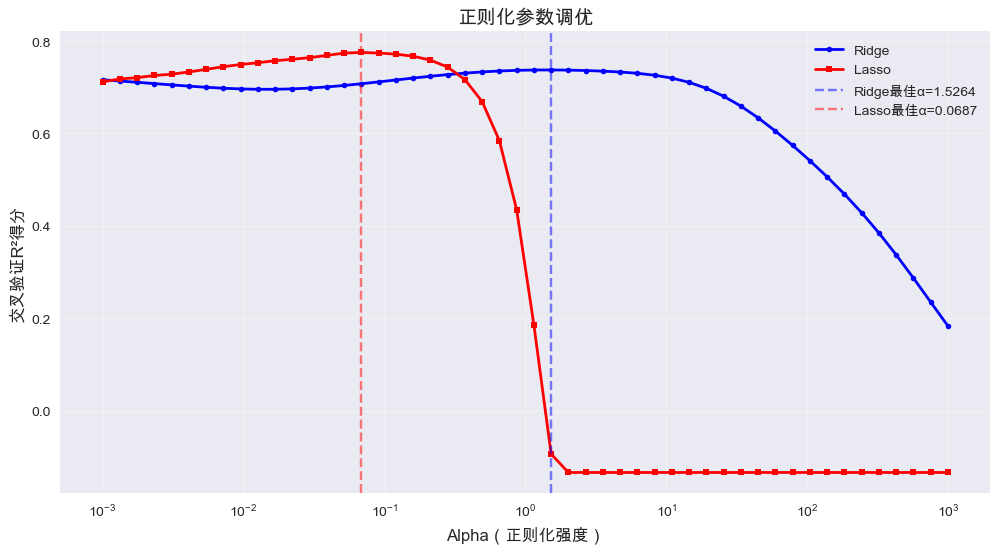

In [20]:
# 可视化alpha vs 性能
ridge_scores = []
lasso_scores = []

for alpha in alphas:
    # Ridge
    ridge = Ridge(alpha=alpha)
    ridge_score = cross_val_score(ridge, X_train_scaled, y_train, cv=5, 
                                   scoring='r2').mean()
    ridge_scores.append(ridge_score)
    
    # Lasso
    lasso = Lasso(alpha=alpha, max_iter=50000)
    lasso_score = cross_val_score(lasso, X_train_scaled, y_train.ravel(), cv=5, 
                                   scoring='r2').mean()
    lasso_scores.append(lasso_score)

plt.figure(figsize=(12, 6))
plt.semilogx(alphas, ridge_scores, 'b-o', label='Ridge', linewidth=2, markersize=4)
plt.semilogx(alphas, lasso_scores, 'r-s', label='Lasso', linewidth=2, markersize=4)
plt.axvline(ridge_cv.alpha_, color='b', linestyle='--', alpha=0.5, 
            label=f'Ridge最佳α={ridge_cv.alpha_:.4f}')
plt.axvline(lasso_cv.alpha_, color='r', linestyle='--', alpha=0.5, 
            label=f'Lasso最佳α={lasso_cv.alpha_:.4f}')
plt.xlabel('Alpha（正则化强度）', fontsize=12)
plt.ylabel('交叉验证R²得分', fontsize=12)
plt.title('正则化参数调优', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.show()

## 5. ElasticNet（结合L1和L2）

In [21]:
from sklearn.linear_model import ElasticNetCV

# ElasticNet交叉验证
elasticnet_cv = ElasticNetCV(alphas=alphas, cv=5, max_iter=50000, l1_ratio=0.5)
elasticnet_cv.fit(X_train_scaled, y_train.ravel())

print(f'ElasticNet最佳alpha: {elasticnet_cv.alpha_:.4f}')
print(f'ElasticNet测试集R²: {elasticnet_cv.score(X_test_scaled, y_test):.4f}')
print(f'ElasticNet选择的特征数: {np.sum(np.abs(elasticnet_cv.coef_) > 1e-5)}/{len(elasticnet_cv.coef_)}')

ElasticNet最佳alpha: 0.0687
ElasticNet测试集R²: 0.8576
ElasticNet选择的特征数: 4/20


## 6. 使用Pipeline简化流程

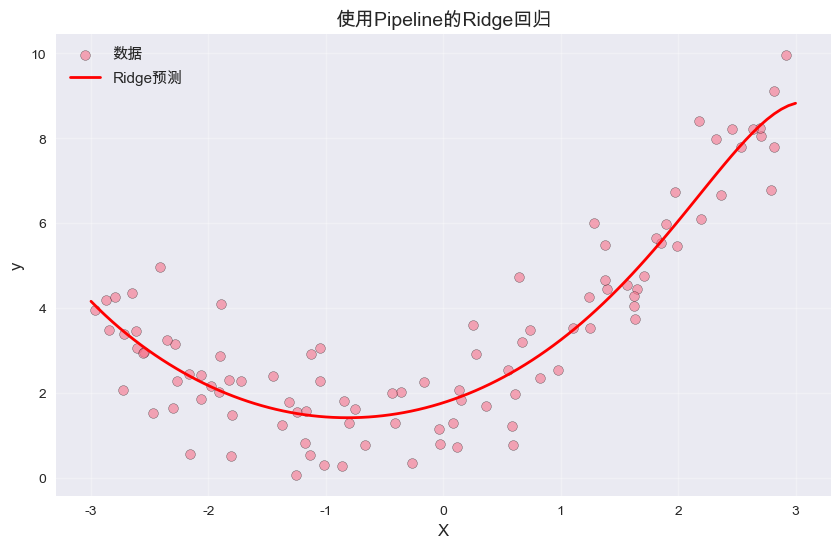

Pipeline步骤: dict_keys(['polynomialfeatures', 'standardscaler', 'ridge'])


In [22]:
from sklearn.pipeline import make_pipeline

# 创建Pipeline
ridge_pipeline = make_pipeline(
    PolynomialFeatures(degree=10),
    StandardScaler(),
    Ridge(alpha=1)
)

# 训练
ridge_pipeline.fit(X, y)

# 预测
X_plot = np.linspace(-3, 3, 100).reshape(-1, 1)
y_plot = ridge_pipeline.predict(X_plot)

# 可视化
plt.figure(figsize=(10, 6))
plt.scatter(X, y, alpha=0.6, edgecolors='k', label='数据')
plt.plot(X_plot, y_plot, 'r-', linewidth=2, label='Ridge预测')
plt.xlabel('X', fontsize=12)
plt.ylabel('y', fontsize=12)
plt.title('使用Pipeline的Ridge回归', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.show()

print('Pipeline步骤:', ridge_pipeline.named_steps.keys())

## 7. 实战练习

### 练习1：特征选择
使用Lasso进行自动特征选择，找出最重要的特征

In [12]:
# TODO: 创建包含50个特征的数据集，其中只有5个是有用的
from sklearn.datasets import make_regression

X_sparse, y_sparse = make_regression(
    n_samples=200,
    n_features=50,
    n_informative=5,
    noise=10,
    random_state=42
)

# 使用Lasso找出重要特征
# 你的代码...

### 练习2：GridSearchCV调参
使用GridSearchCV同时优化多项式阶数和正则化参数

In [13]:
# TODO: 使用GridSearchCV
from sklearn.model_selection import GridSearchCV

# 定义参数网格
param_grid = {
    'polynomialfeatures__degree': [1, 2, 3, 4, 5],
    'ridge__alpha': [0.001, 0.01, 0.1, 1, 10]
}

# 你的代码...

### 练习3：正则化路径
绘制不同alpha下权重的变化曲线（Regularization Path）

In [14]:
# TODO: 绘制Lasso的正则化路径
# 提示：使用sklearn.linear_model.lasso_path

# 你的代码...

## 8. 总结

### 学到的知识点
- ✅ 多项式回归处理非线性关系
- ✅ 过拟合和欠拟合的识别
- ✅ Ridge（L2）vs Lasso（L1）vs ElasticNet
- ✅ 特征缩放的重要性
- ✅ 交叉验证选择超参数
- ✅ Pipeline简化工作流

### Ridge vs Lasso 选择指南

| 场景 | 推荐方法 | 原因 |
|------|---------|------|
| 所有特征都有用 | Ridge | 保留所有特征，权重变小 |
| 只有少数特征有用 | Lasso | 自动特征选择，稀疏解 |
| 特征高度相关 | Ridge或ElasticNet | Lasso可能随机选择 |
| 需要特征选择 | Lasso | 权重置零 |
| 不确定 | ElasticNet | 结合两者优点 |

### 关键要点
1. **正则化之前必须标准化特征**
2. **使用交叉验证选择alpha**
3. **学习曲线帮助诊断过拟合/欠拟合**
4. **Pipeline让代码更简洁且避免数据泄漏**

---

### 下一步
接下来我们将进入实战项目：房价预测，综合应用所学知识！